In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from math import sqrt

import DataAid
import Neros

In [2]:
# Collect the data from each of the folders
sparcGalaxies = DataAid.GetGalaxyData("data/Sparc/Rotmod_LTG/")
littleDataGalaxies = DataAid.GetGalaxyData("data/little-data-things/")
xueSofueGalaxies = DataAid.GetGalaxyData("data/XueSofue/")
# Get the galaxies we want from each source
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])

# chi squared function
def chiSquared(observed, expected, error):
    chiSquared = 0
    
    for i in range(len(observed)):
        chiSquared = chiSquared + (((observed[i] - expected[i])**2) / (error[i]**2))
        
    return chiSquared / len(observed)

# Fit function
def simple(independents, alpha, vLumFreeParam, phiZero):
    # Parse out data for the galaxy
    rad,vLum = independents
    # Apply the vLum free param to the data
    vLum = vLum*vLumFreeParam
    # Calc vLCM with alpha free param
    vLcm = Neros.vLcm(rad, MW_vLum_interp_func(rad), vLum, phiZero)
    # Calc and return vNeros
    return Neros.vNeros(vLum, vLcm, alpha)

## Create the Milky Way interpolation function

In [3]:
MW_rad = MWXueSofue[:,0]
MW_vLum = MWXueSofue[:,1]
# Interpolation function
MW_vLum_interp_func = interp1d(MW_rad, MW_vLum, kind='cubic')

## Running VNeros on every galaxy
We calculate vNeros for each galaxy and then plot the ratio between vNeros and the galaxy's vObs

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


galaxyName is: ddo47_rotmas_input_velocities
chiSquare is: 4.847799895624614
fittedAlpha is: -1004.623730183994, 
fittedVLumFreeParam is: 0.13815512203744032
--------------------------
galaxyName is: ngc2366_rotmas_input_velocities
chiSquare is: 1.398146085112186
fittedAlpha is: -95.19397419249177, 
fittedVLumFreeParam is: 1.9352756416498578
--------------------------
galaxyName is: ic1613_rotmas_input_velocities
chiSquare is: 0.2768481861608723
fittedAlpha is: 15501.956449583218, 
fittedVLumFreeParam is: 0.9417659299799621
--------------------------
galaxyName is: ddo43_rotmas_input_velocities
chiSquare is: 1.5914296226822868
fittedAlpha is: -3468.0995996441848, 
fittedVLumFreeParam is: 0.10767076237658564
--------------------------
galaxyName is: ddo46_rotmas_input_velocities
chiSquare is: 44.17552742394284
fittedAlpha is: 6269.887365507902, 
fittedVLumFreeParam is: 2.0173346259199763
--------------------------


/Users/sophiacisneros/Desktop/RCFM/RCFM/Neros.py:78: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.square(Other_Vlum) + (vLCM*freeParam) )


galaxyName is: haro36_rotmas_input_velocities
chiSquare is: 0.1591209718297988
fittedAlpha is: 30745.616061788875, 
fittedVLumFreeParam is: 1.0135360133100209
--------------------------
galaxyName is: ddo133_rotmas_input_velocities
chiSquare is: 25.08808728178691
fittedAlpha is: 30219.867797715036, 
fittedVLumFreeParam is: 1.4552696907230562
--------------------------
galaxyName is: f564_v3_rotmas_input_velocities
chiSquare is: 8.63716153869869
fittedAlpha is: 9507.03611212455, 
fittedVLumFreeParam is: 1.6684652405001892
--------------------------
galaxyName is: ddo50_rotmas_input_velocities
chiSquare is: 5.718187800721662
fittedAlpha is: 561.1010672751926, 
fittedVLumFreeParam is: 1.0369880386234982
--------------------------
galaxyName is: ddo168_rotmas_input_velocities
chiSquare is: 4.745637968618578
fittedAlpha is: 8497.012465258966, 
fittedVLumFreeParam is: 1.3185141307227388
--------------------------
galaxyName is: wlm_rotmas_input_velocities
chiSquare is: 8.233344591806816
fitt

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


galaxyName is: ddo126_rotmas_input_velocities
chiSquare is: 4.167973693704415
fittedAlpha is: 29471.35050062999, 
fittedVLumFreeParam is: 1.2721242743804972
--------------------------
galaxyName is: ugc8508_rotmas_input_velocities
chiSquare is: 6.680350898152735
fittedAlpha is: 3783.9896310628947, 
fittedVLumFreeParam is: 3.7872697873012875
--------------------------
galaxyName is: ddo101_rotmas_input_velocities
chiSquare is: 44.24516857034604
fittedAlpha is: 24682.903331637008, 
fittedVLumFreeParam is: 2.2750368892332724
--------------------------
galaxyName is: cvnidwa_rotmas_input_velocities
chiSquare is: 0.4323450756324584
fittedAlpha is: 130033.16232028317, 
fittedVLumFreeParam is: 0.8528354766758288
--------------------------
galaxyName is: ddo87_rotmas_input_velocities
chiSquare is: 2.3813136790331675
fittedAlpha is: -491.8792719391116, 
fittedVLumFreeParam is: 3.0657400842037394
--------------------------
galaxyName is: ddo52_rotmas_input_velocities
chiSquare is: 2.385896238017

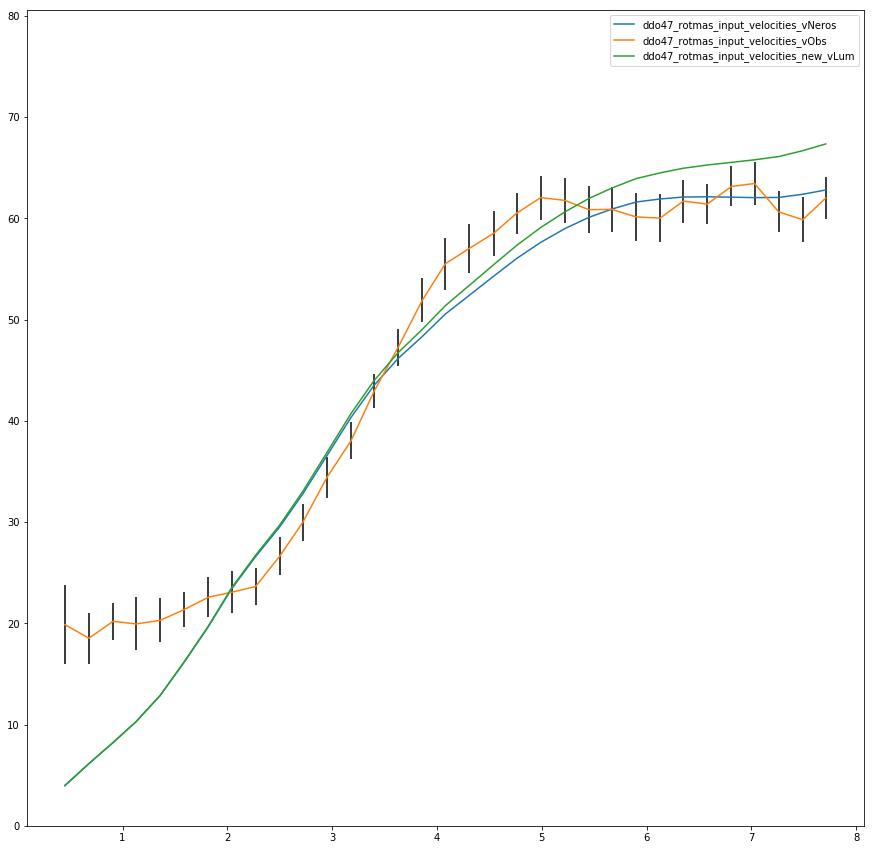

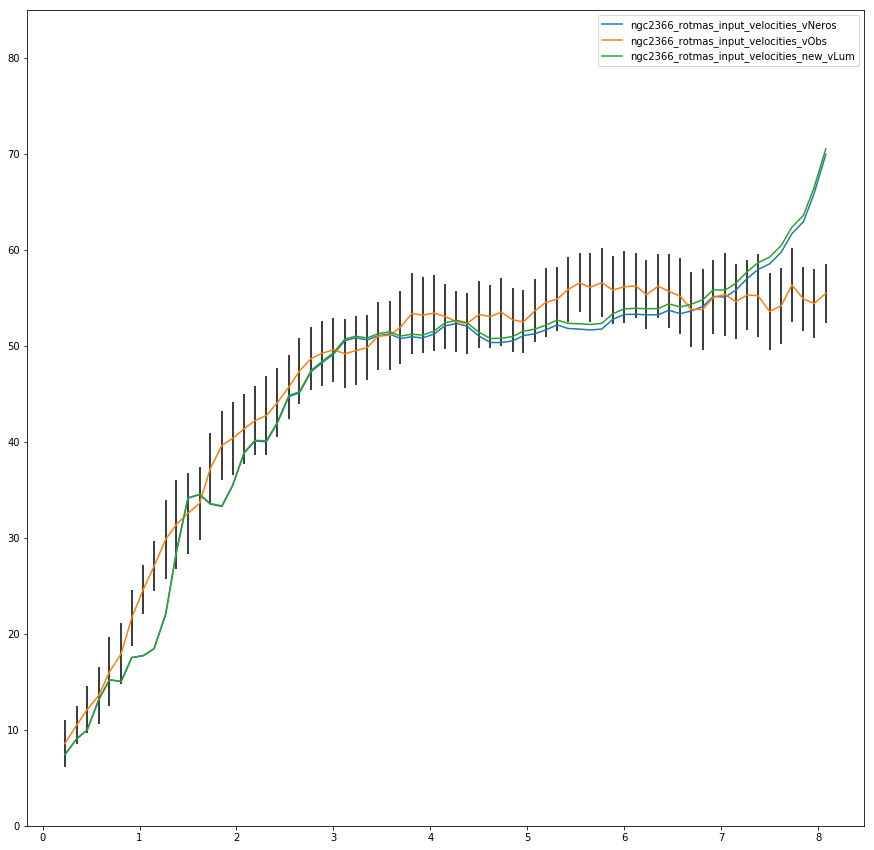

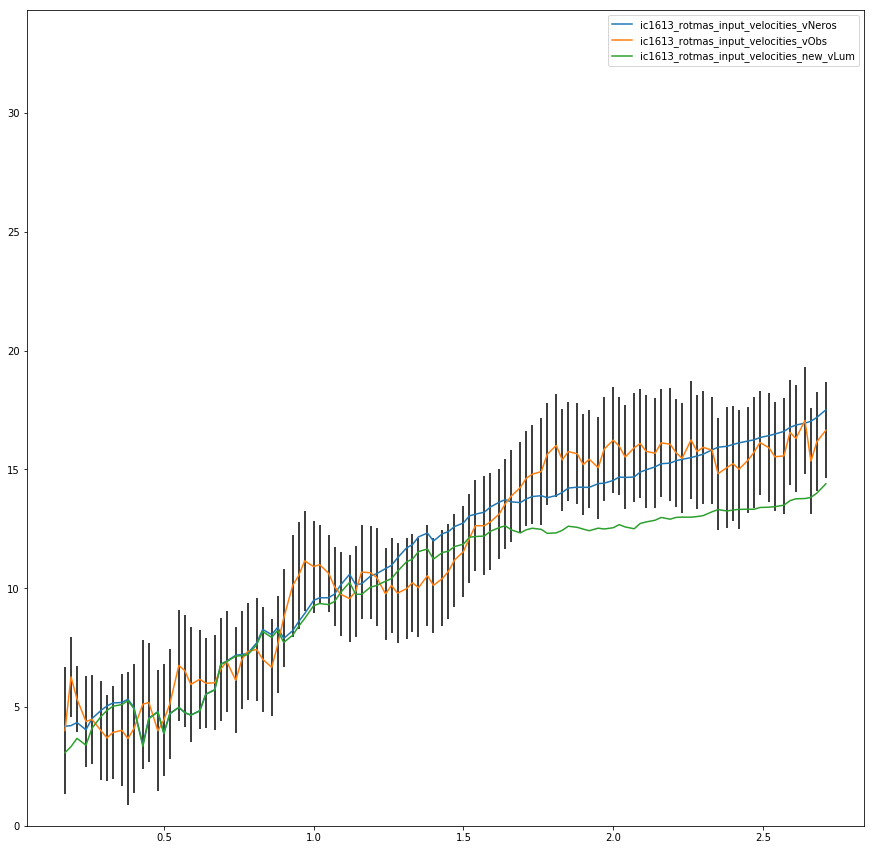

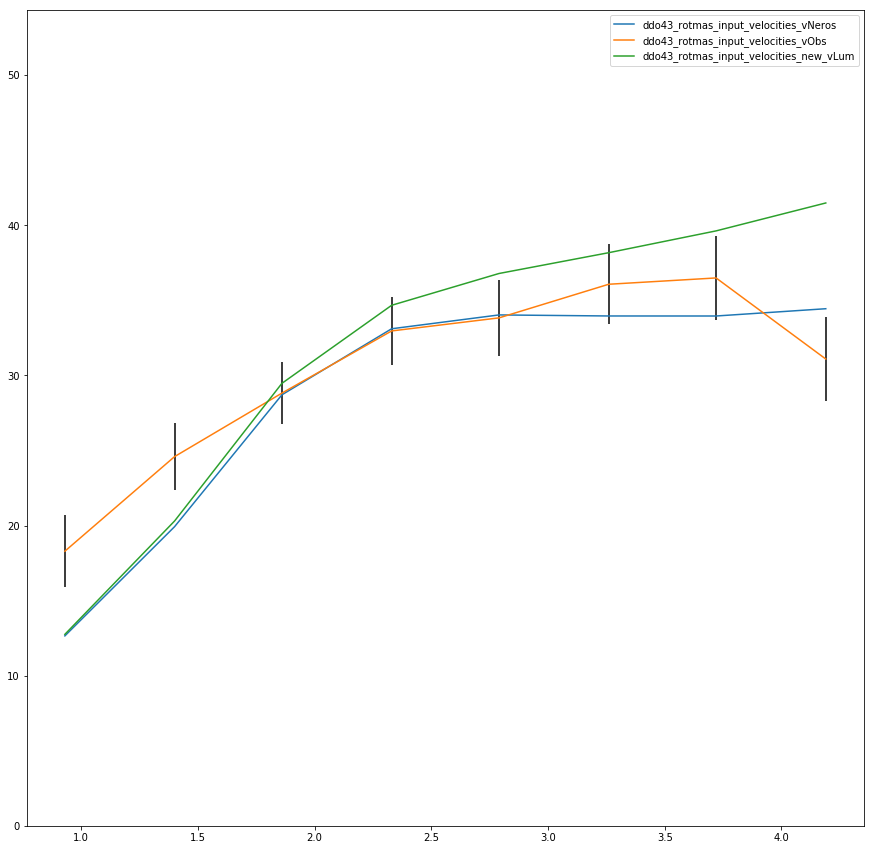

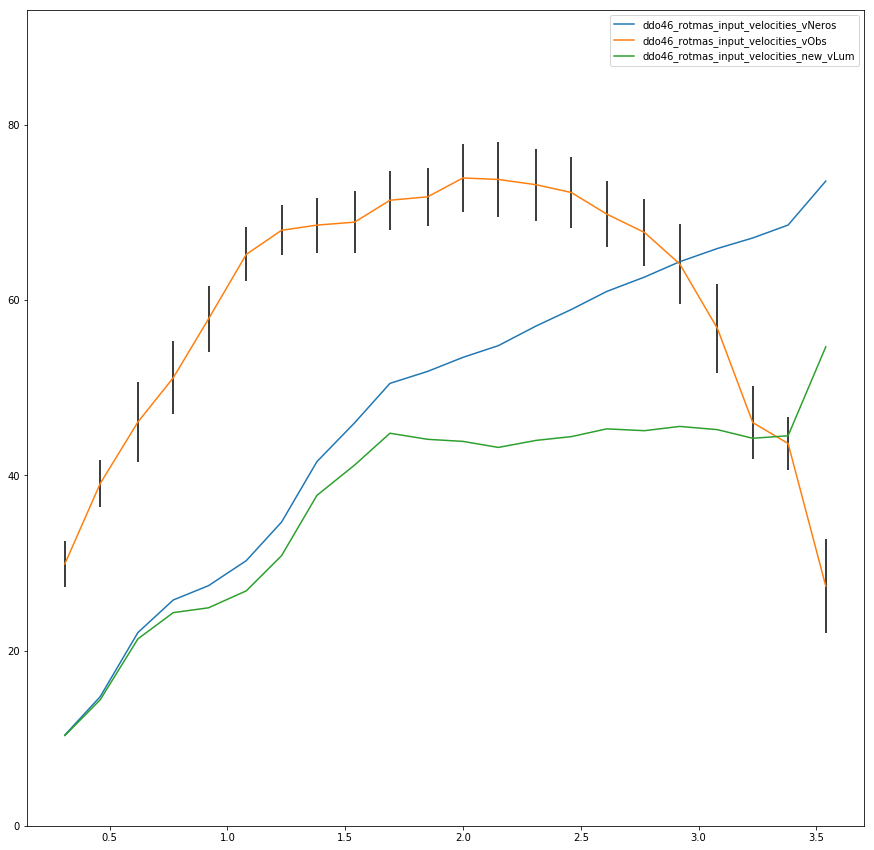

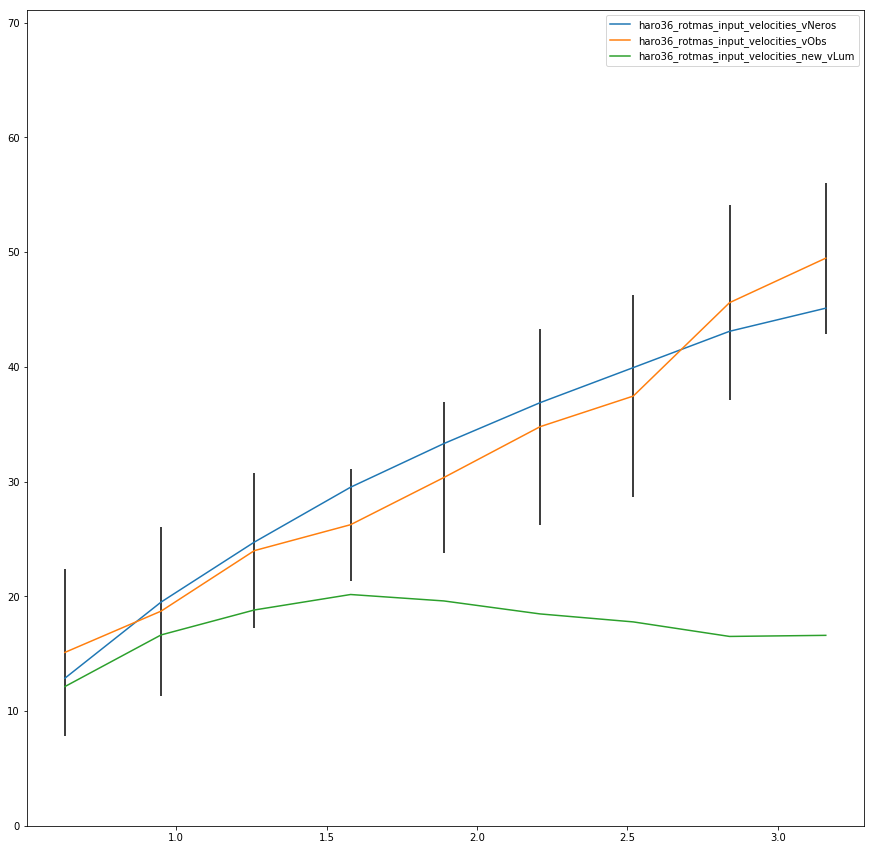

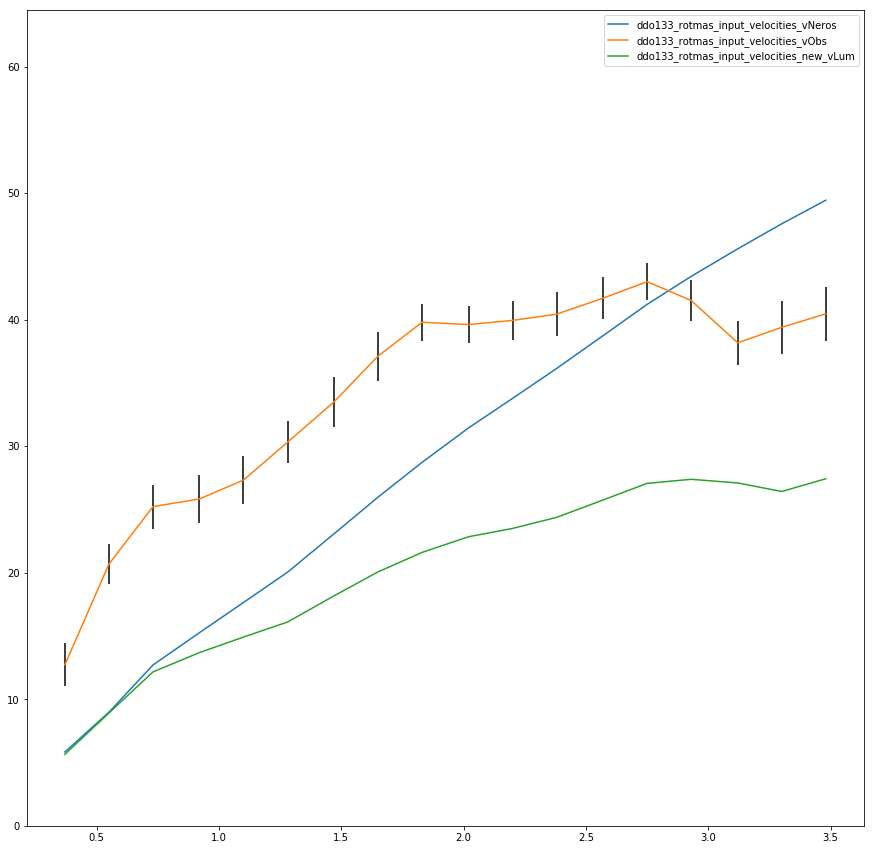

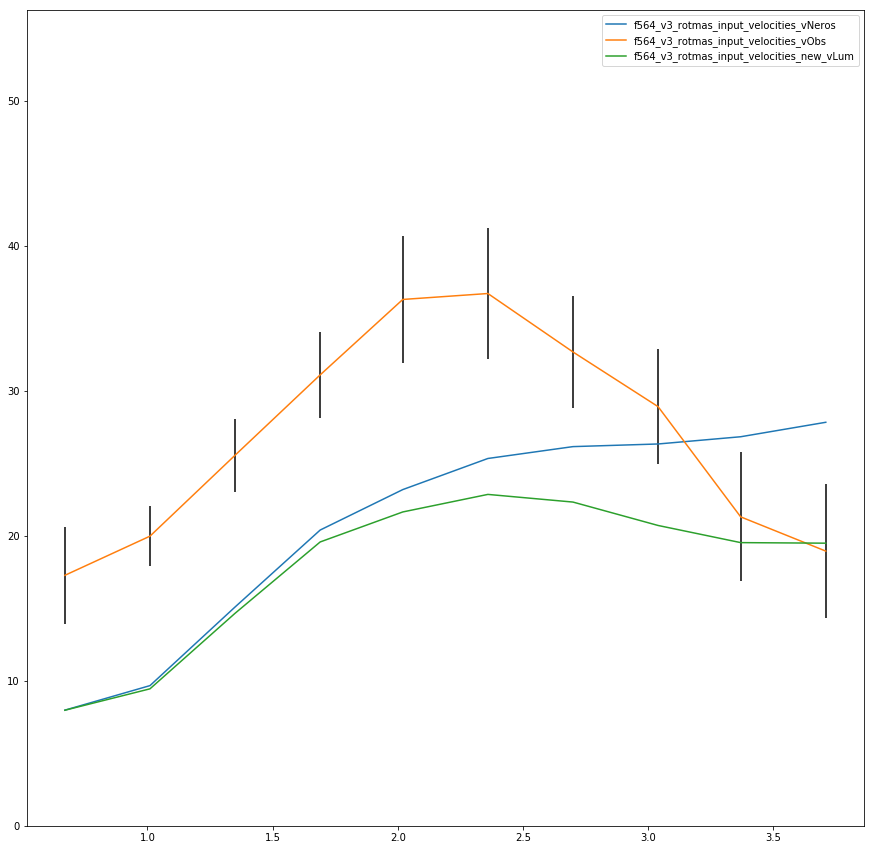

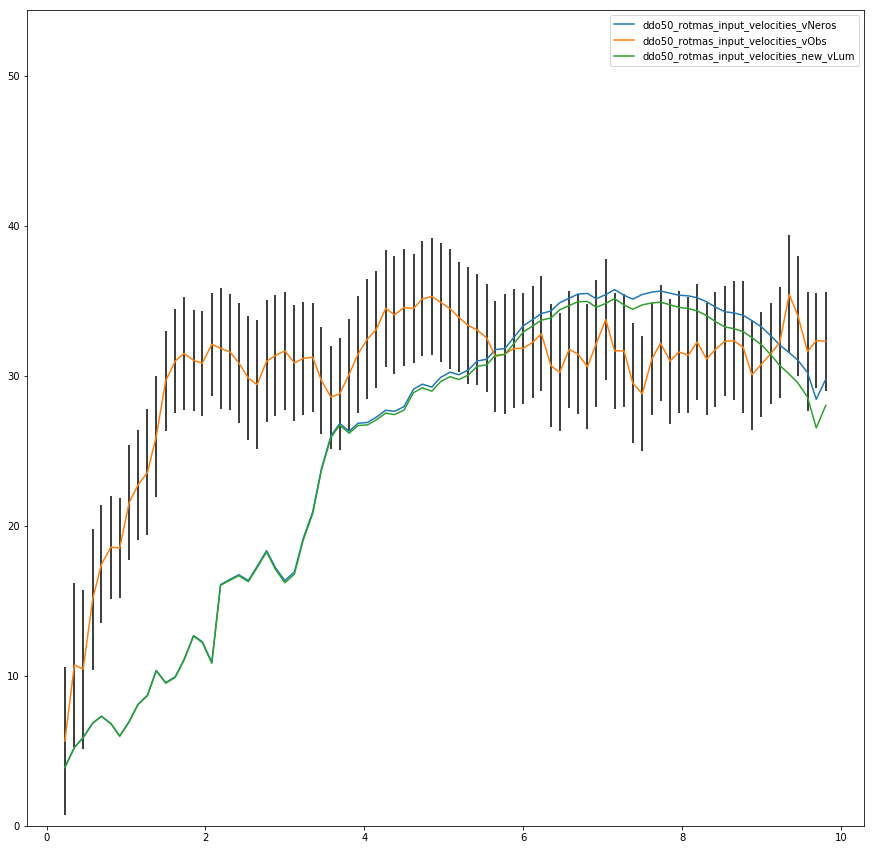

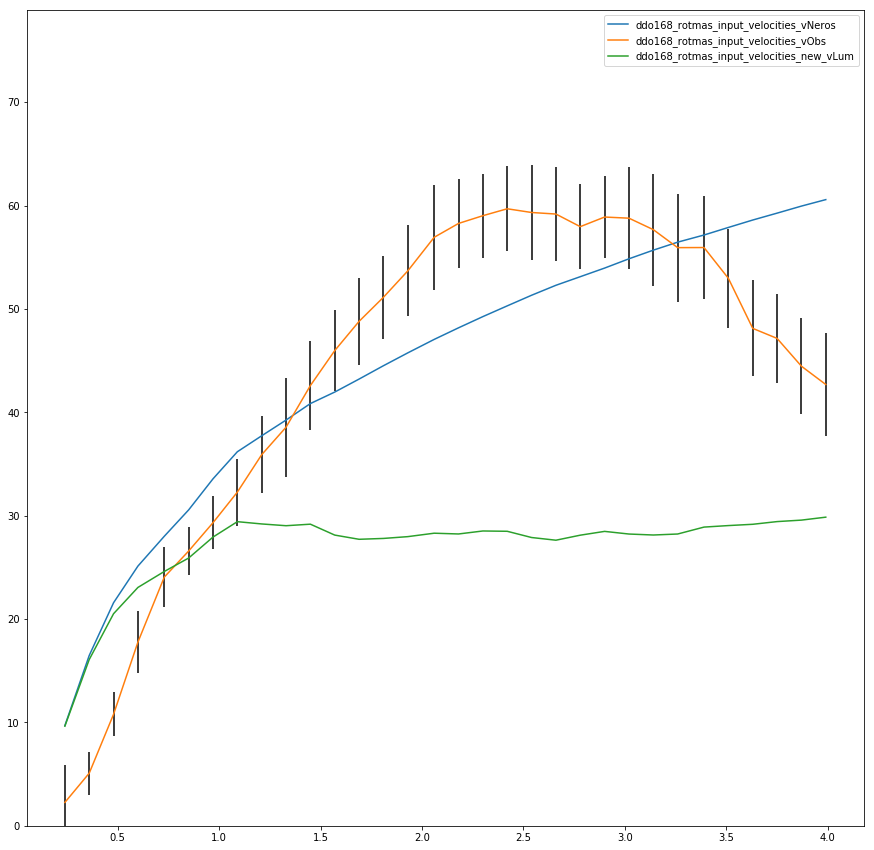

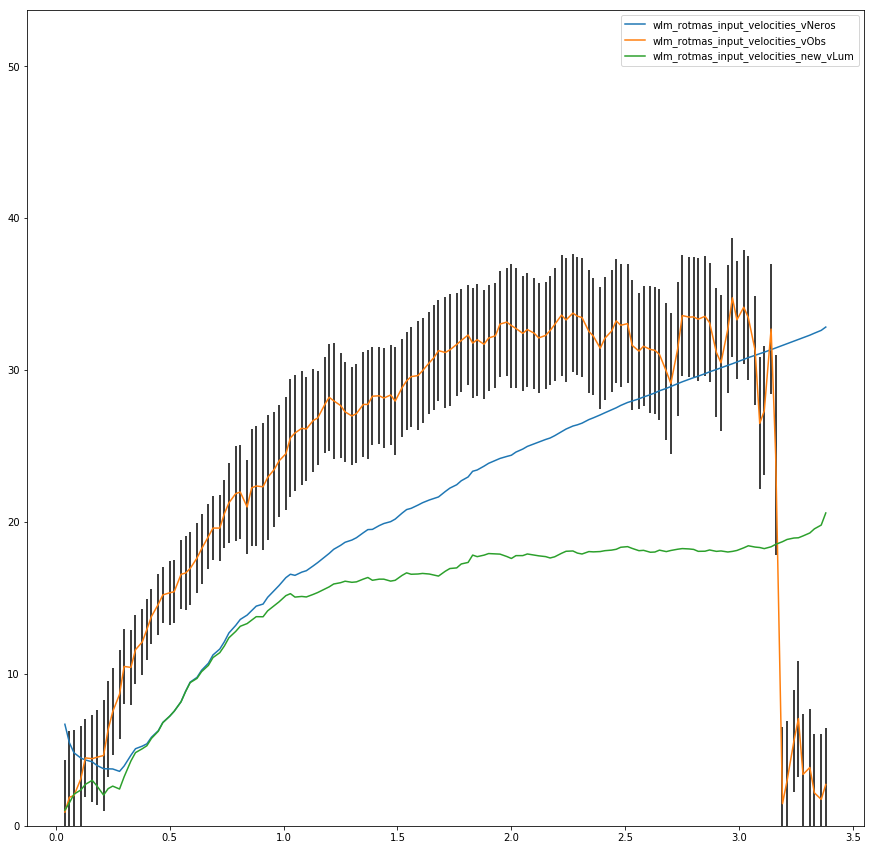

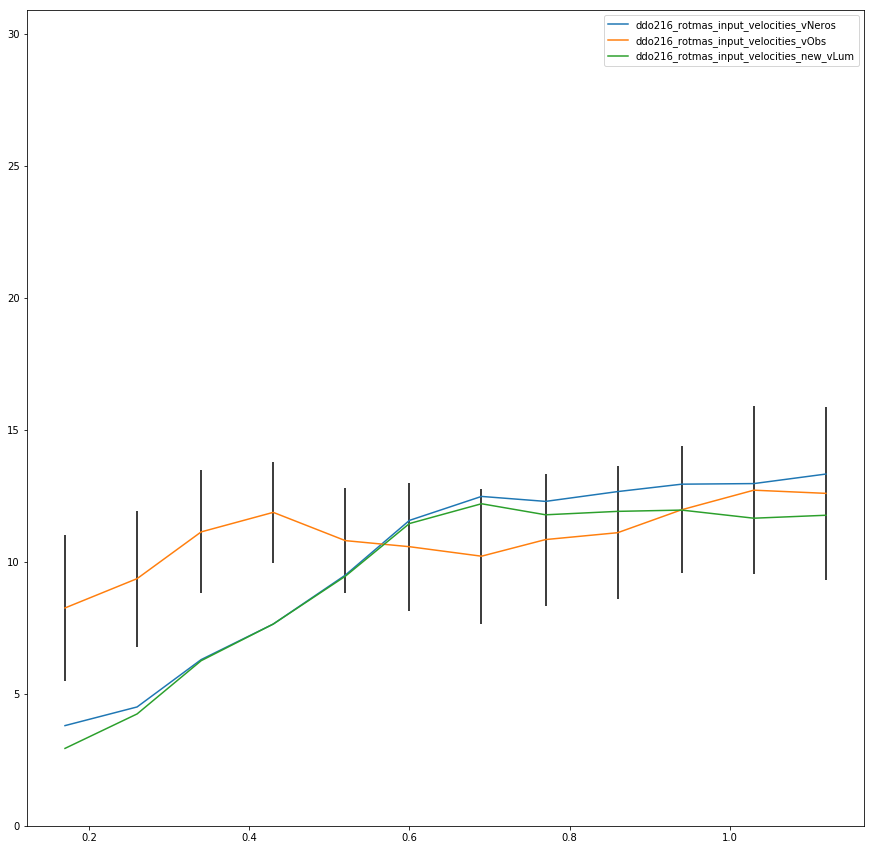

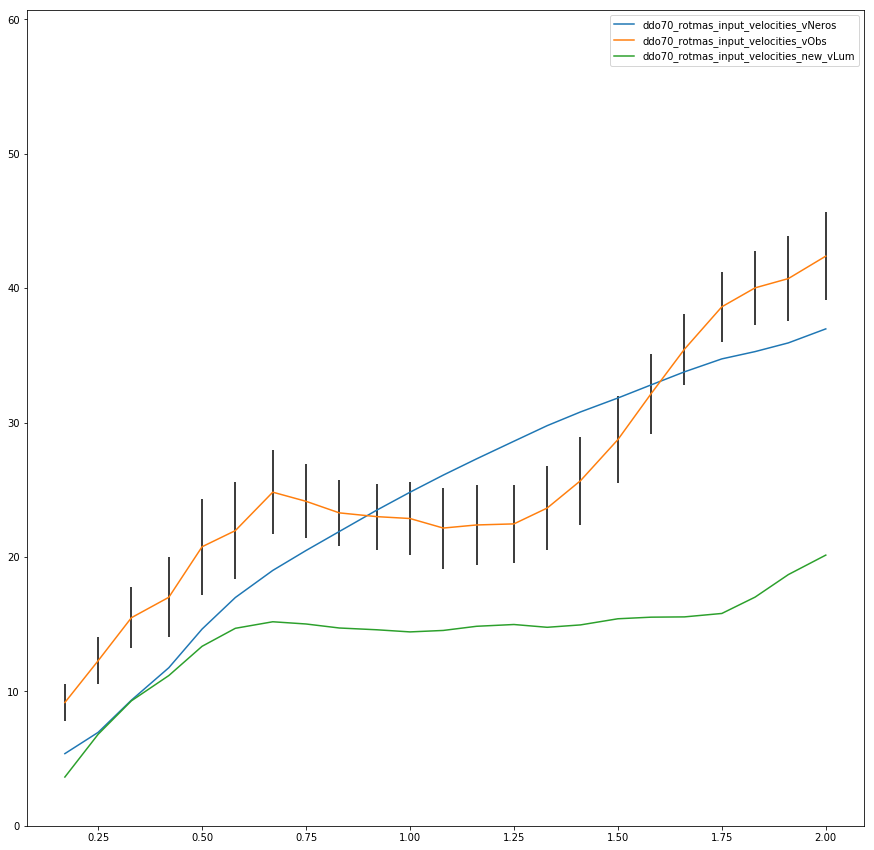

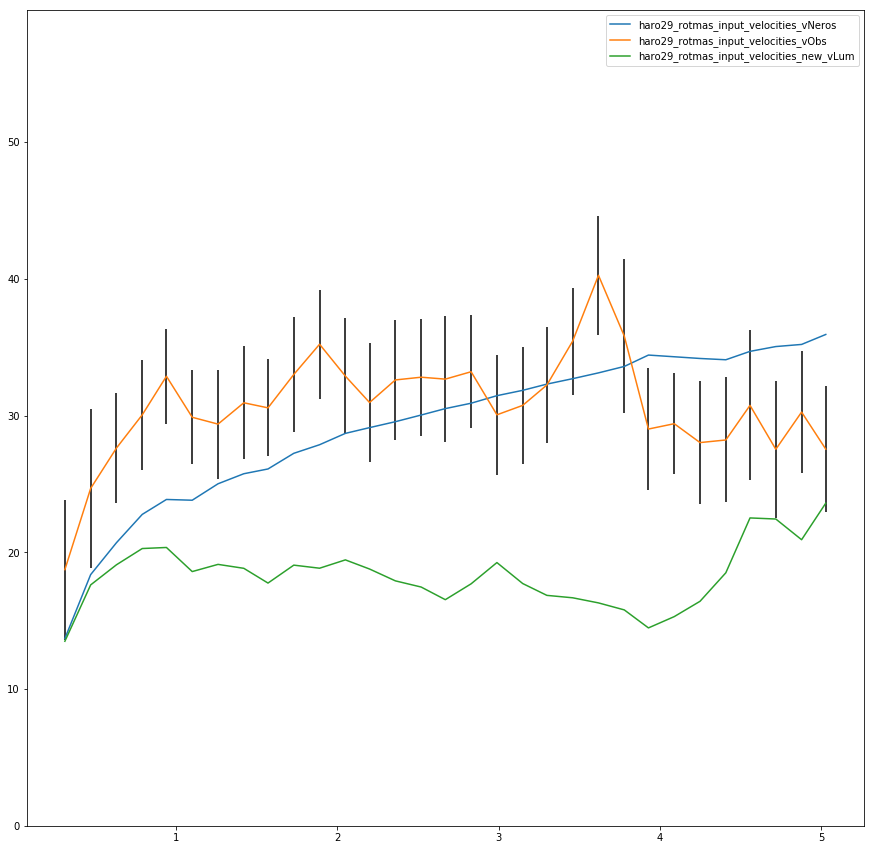

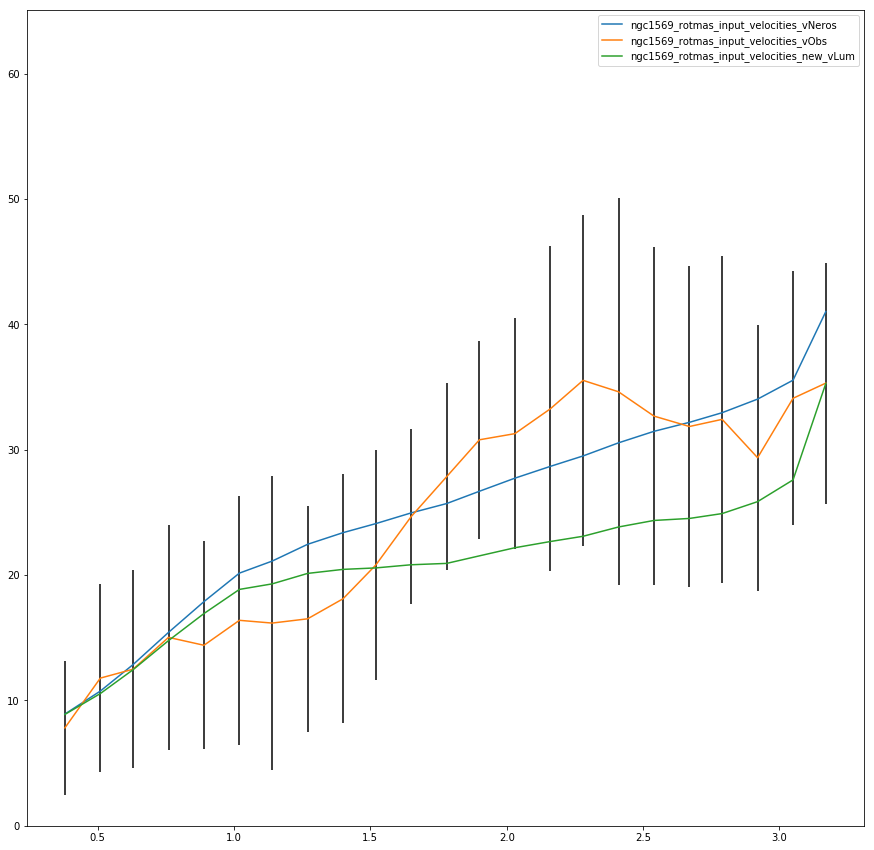

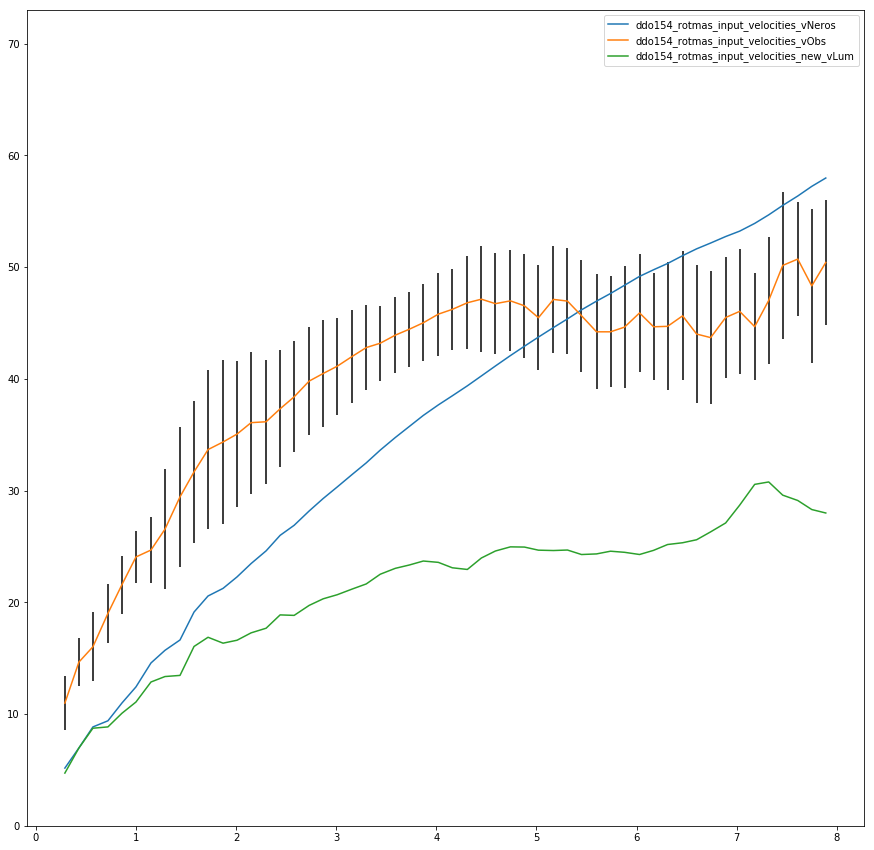

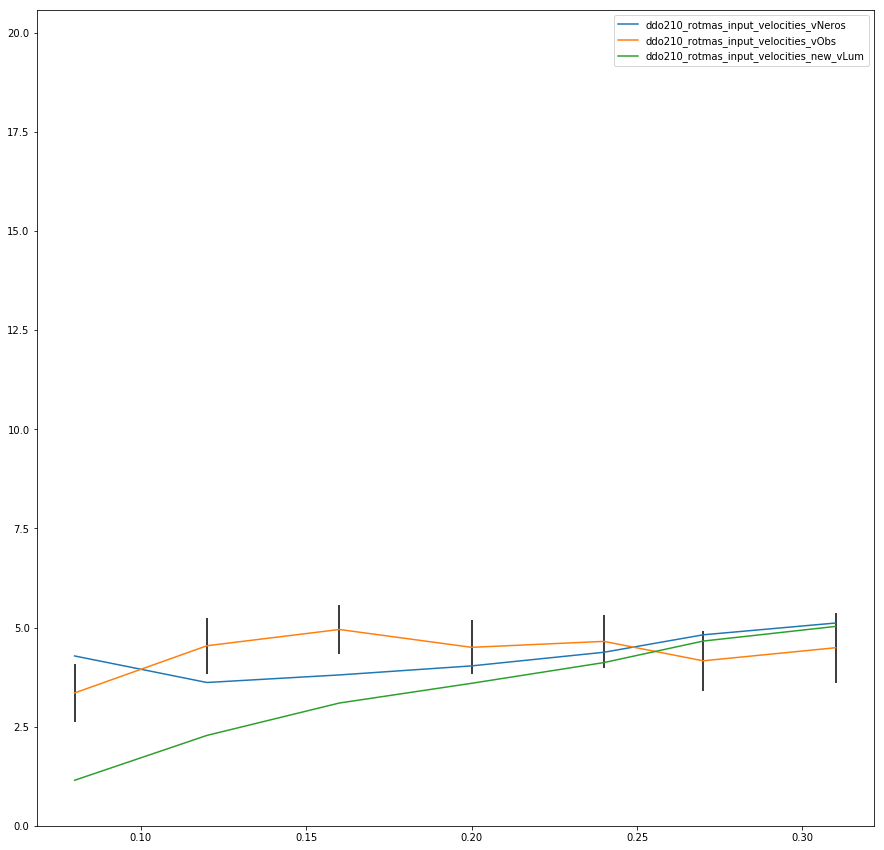

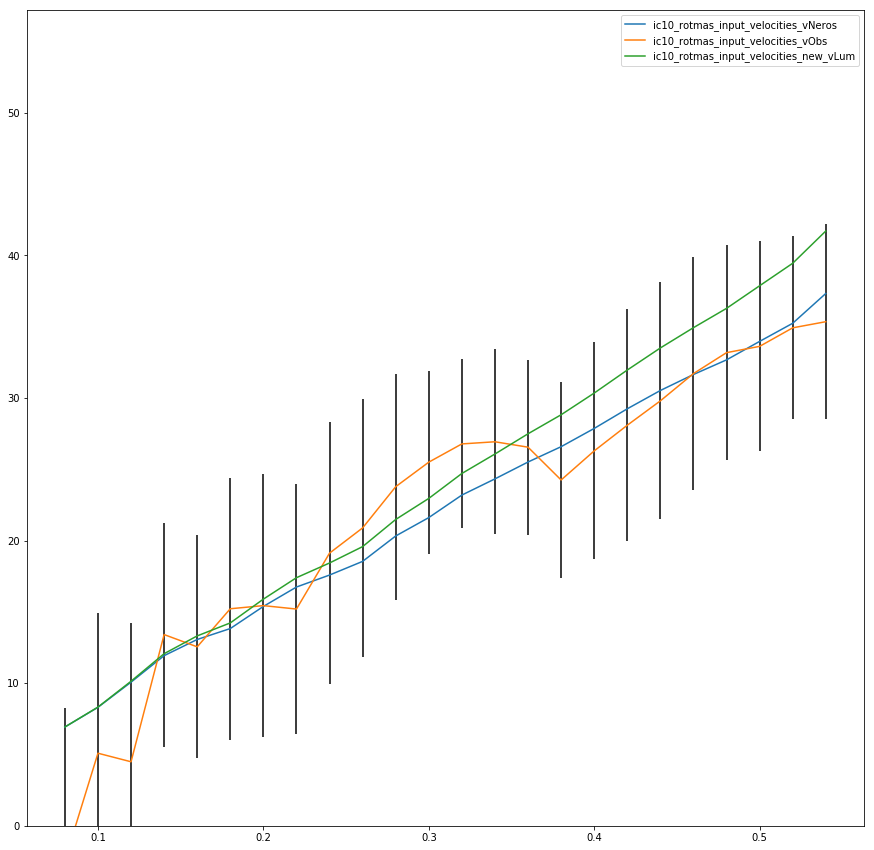

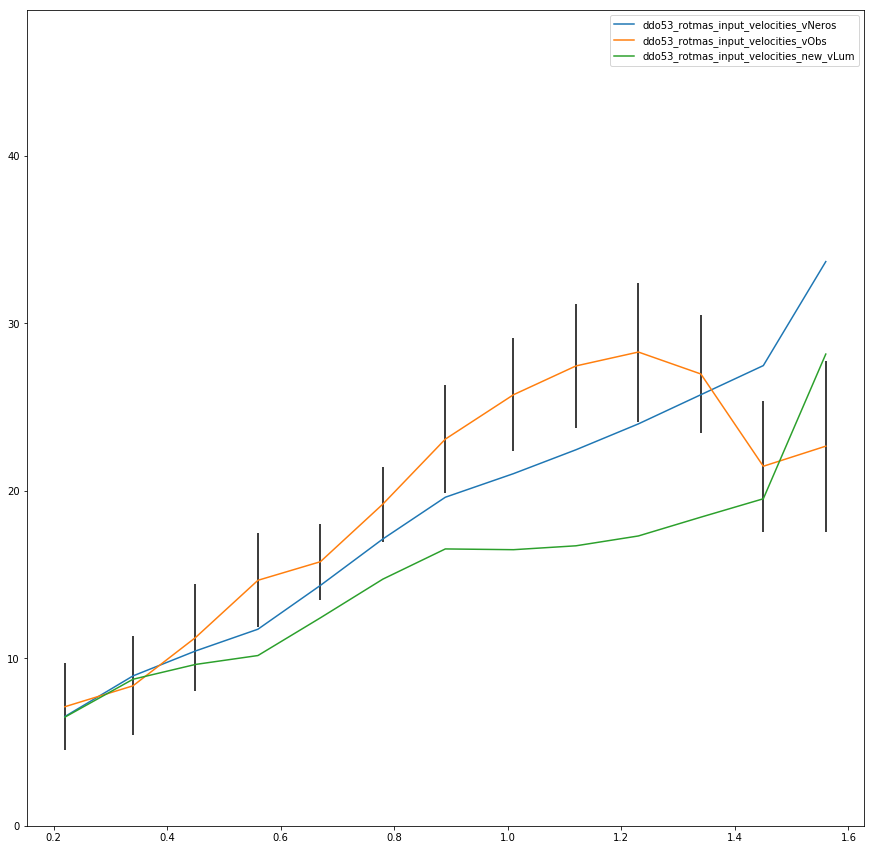

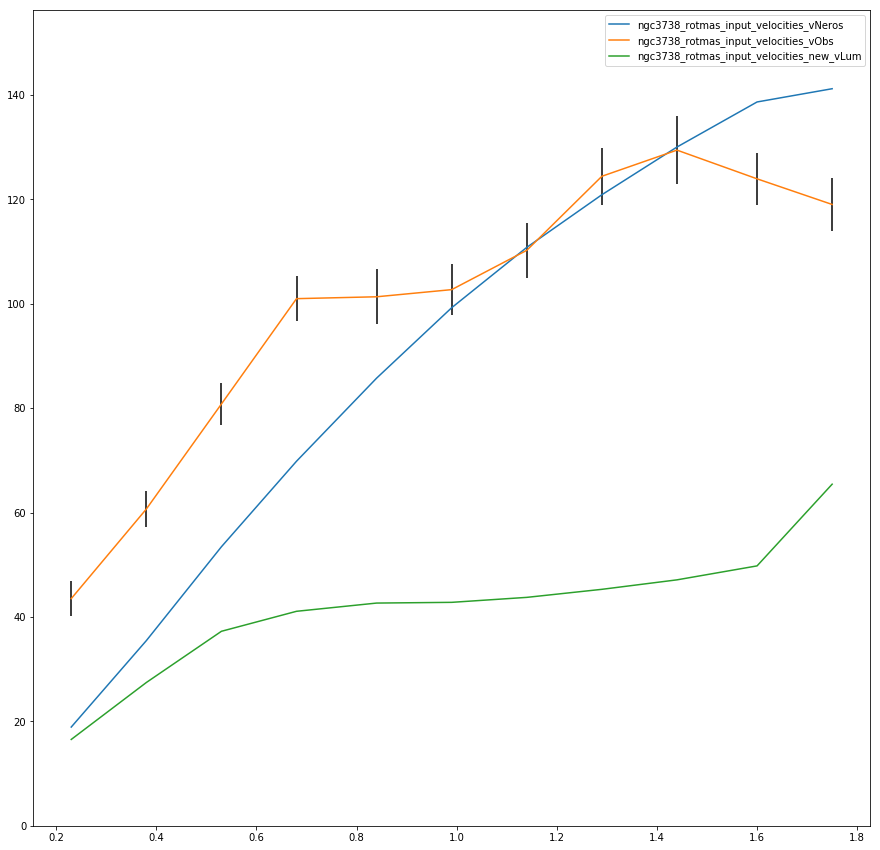

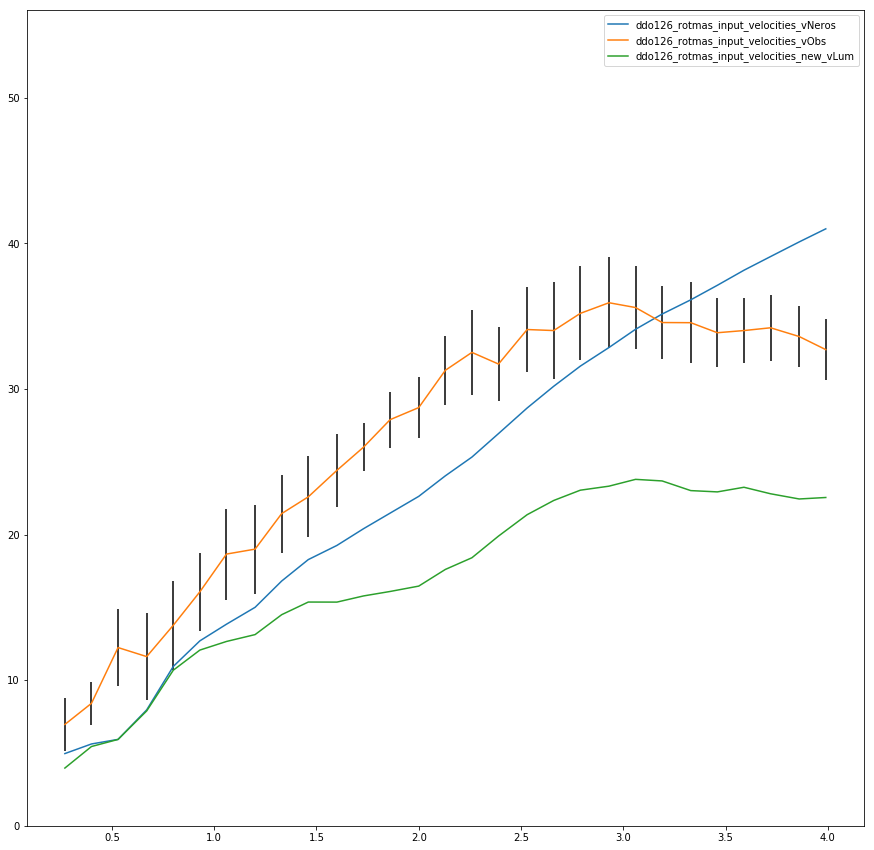

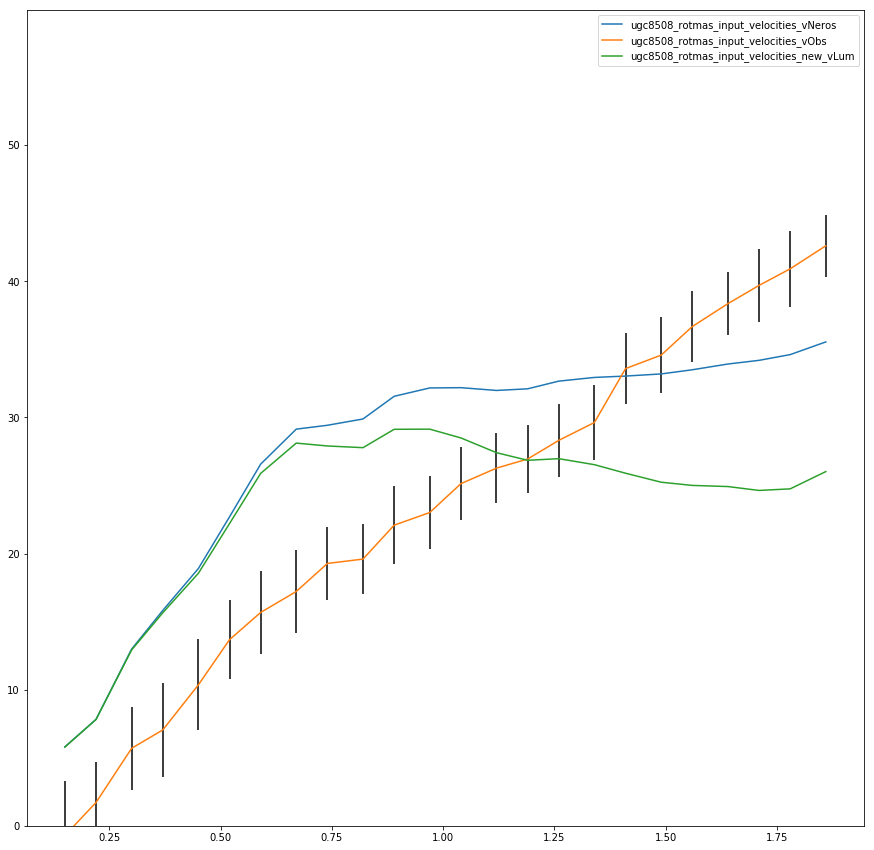

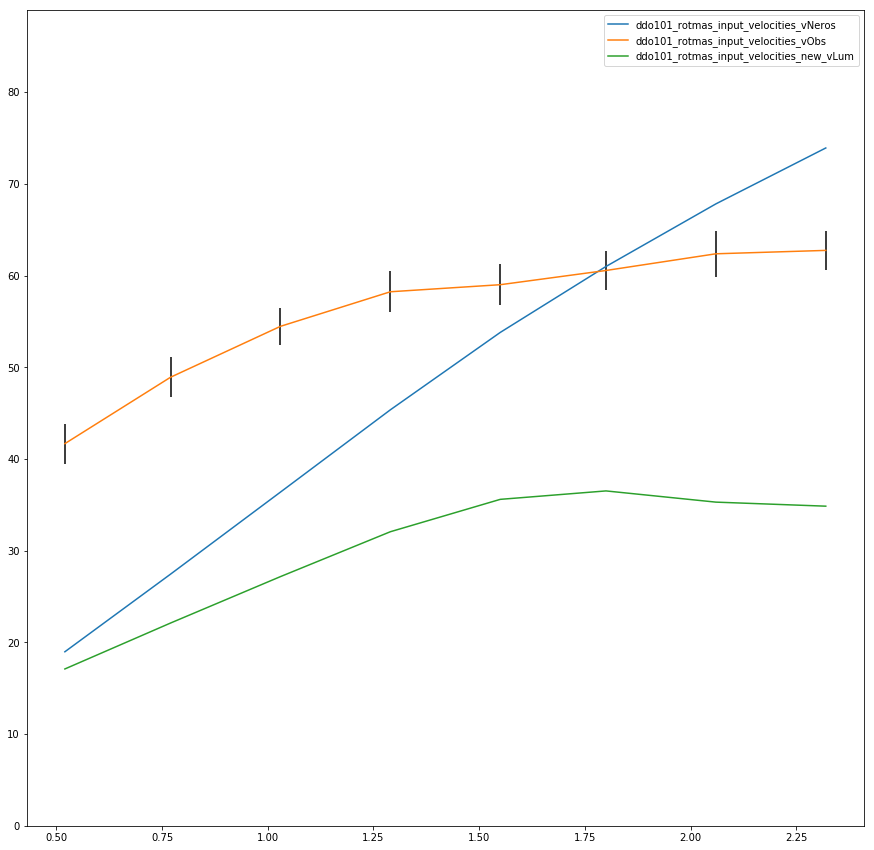

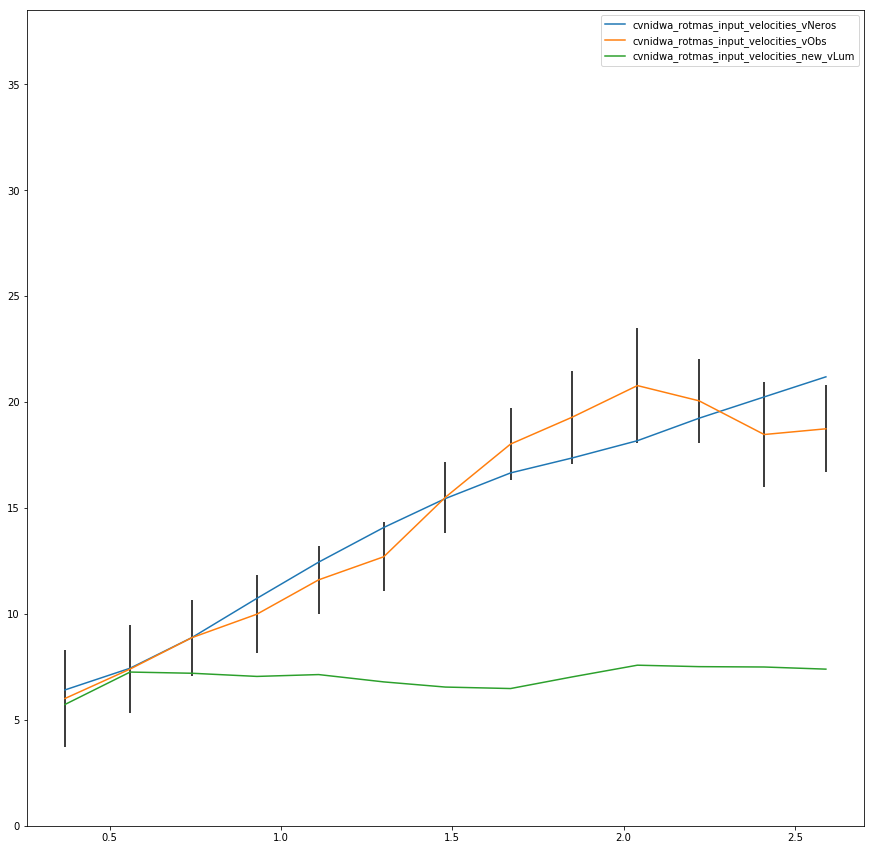

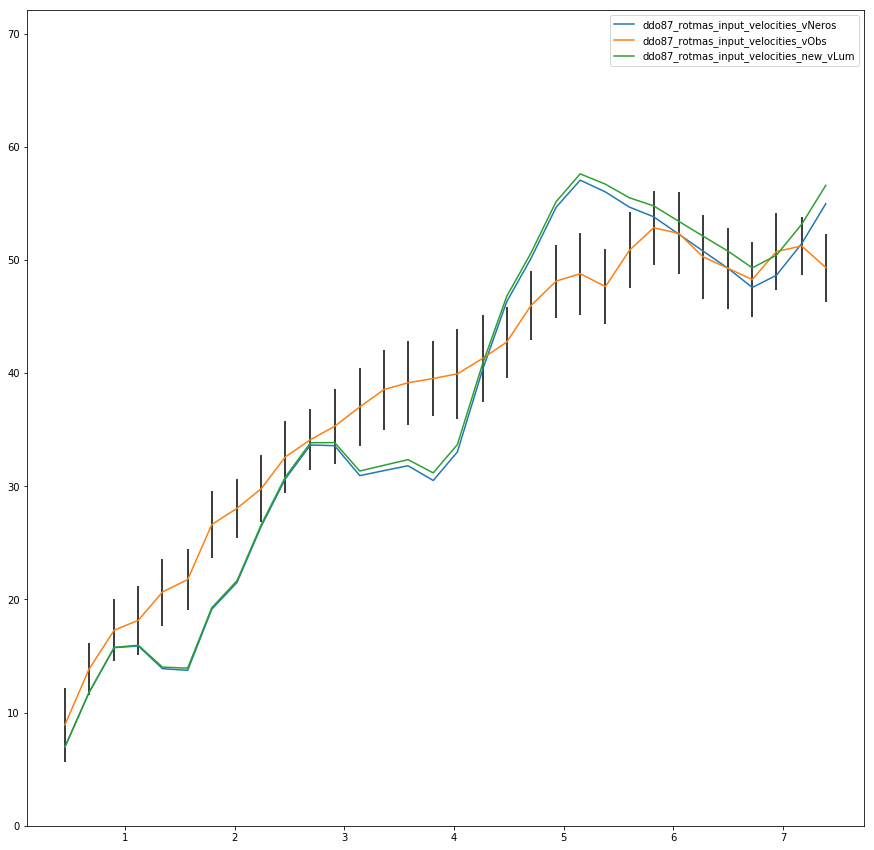

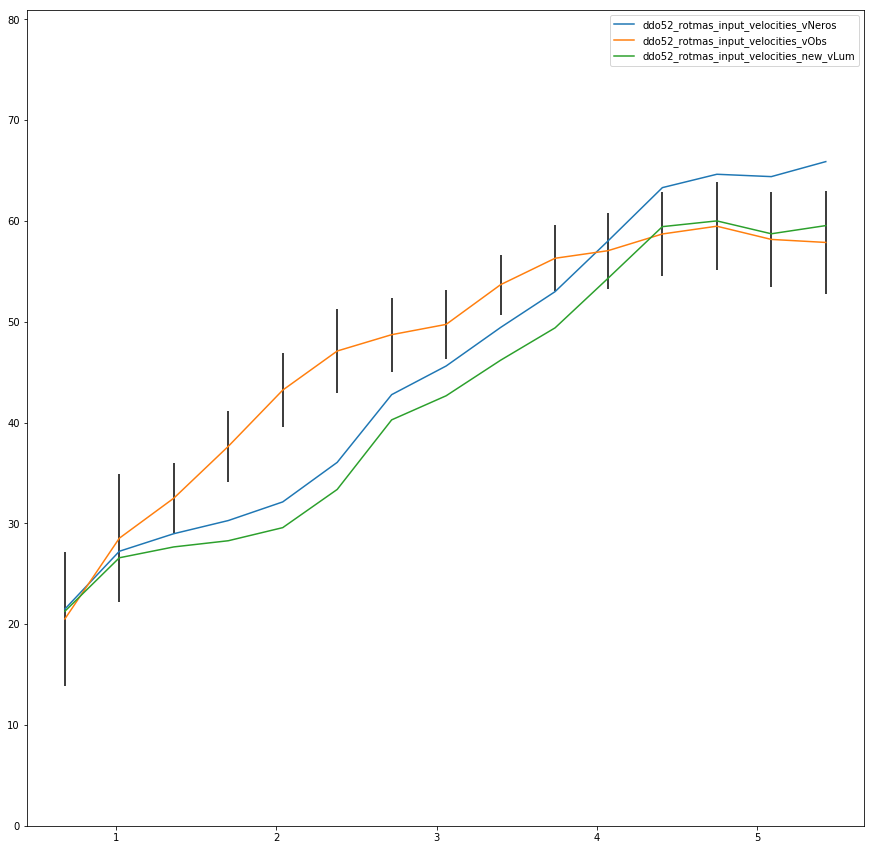

In [4]:
# This is where the fitted alpha & vlum free parameter will be written for each galaxy
out_file = "imported-data/data.csv"
with open(out_file, 'w') as f:
    f.write('{0},{1},{2}\n'.format("Galaxy", "Alpha", "Beta"))
f.close()

vLcmList = []

avgChiSquared = 0.0
avgPhiZero = 0.0

# Change this and uncomment if statement below if just one galaxy is desired.
galaxyWeWant = "NGC2915_rotmod"

for galaxyName in littleDataGalaxies:
    f, ax = plt.subplots(1, figsize = (15, 15))
    # Uncomment the following two lines to produce data and graphs for just galaxyWeWant
    # if (galaxyName != galaxyWeWant):
        # continue
    
    # data on this galaxy
    galaxy = np.array(littleDataGalaxies[galaxyName])
    galaxy_rad = galaxy[:,0]
    galaxy_vObs = galaxy[:,1]
    galaxy_error = galaxy[:,2]
    galaxy_gas = galaxy[:,3]
    galaxy_disk = galaxy[:,4]
    galaxy_bulge = galaxy[:,5]
    galaxy_vLumSquared = Neros.vLumSquared(galaxy_gas, galaxy_disk, galaxy_bulge)
    galaxy_vLum = np.sqrt(galaxy_vLumSquared)
    
    # Make sure the arrays are matching lengths
    maxMWRad = MW_rad[len(MW_rad)-1]
    for i in range(len(galaxy_rad)):
        if galaxy_rad[i] > maxMWRad:
            galaxy_rad = galaxy_rad[:i]
            galaxy_vLum = galaxy_vLum[:i]
            galaxy_vObs = galaxy_vObs[:i]
            break
    
    # fitter
    vals, cov = curve_fit(simple,(galaxy_rad, galaxy_vLum),galaxy_vObs)
    fittedAlpha, fittedVLumFreeParam, fittedPhiZero = vals

    avgPhiZero = avgPhiZero + fittedPhiZero
    
    # Run vLCM
    vLcm = Neros.vLcm(galaxy_rad, MW_vLum_interp_func(galaxy_rad), galaxy_vLum, fittedPhiZero)
    vLcmList.append(vLcm)
    vNeros = simple((galaxy_rad, galaxy_vLum), fittedAlpha, fittedVLumFreeParam, fittedPhiZero)
    ratio = vNeros/galaxy_vObs
    
    # printing to file & console
    chiSquare = chiSquared(galaxy_vObs, vNeros, galaxy_error)
    avgChiSquared = avgChiSquared + chiSquare
    print(f"galaxyName is: {galaxyName}")
    
    print(f"chiSquare is: {chiSquare}")
    
    print(f"fittedAlpha is: {fittedAlpha}, \nfittedVLumFreeParam is: {fittedVLumFreeParam}")
    
    # print(f"MW_Phi is: {Neros.phi(galaxy_rad, MW_vLum_interp_func(galaxy_rad))}")
    
    # print(f"Other_Phi is: {Neros.phi(galaxy_rad, galaxy_vLum)}")
    
    print("--------------------------")
    
    # Write galaxyName, fittedAlpha, fittedVLumFreeParam to file
    with open(out_file, 'a') as f:
        f.write('{0},{1},{2}\n'.format(galaxyName, fittedAlpha, fittedVLumFreeParam))
    f.close()
    
    # Calculate galaxy_vObs plus error and put into list
    galaxy_vObs_err_incl = []
    for i in range(len(galaxy_vObs)):
        galaxy_vObs_err_incl.append(galaxy_vObs[i] + galaxy_error[i])
        
    # calculate new vLum
    galaxy_vLum_updated = []
    for i in range(len(galaxy_vLum)):
        galaxy_vLum_updated.append(galaxy_vLum[i] * fittedVLumFreeParam)
        
    # plot
    # y-axis scales to the maximum velocity value in the list galaxy_vObs_err_incl
    # or to the maximum value in the list vNeros, whichever is the bigger number
    y_max = max(max(galaxy_vObs_err_incl), max(vNeros))
    ax.set_ylim(bottom = 0, top = y_max + 15)
    
    # plot vObs and vNeros and updated vLum
    ax.plot(galaxy_rad, vNeros, label="{}_vNeros".format(galaxyName))
    ax.plot(galaxy_rad, galaxy_vObs, label="{}_vObs".format(galaxyName))
    ax.plot(galaxy_rad, galaxy_vLum_updated, label="{}_new_vLum".format(galaxyName))
    
    # error bar in vObs
    for i in range(len(galaxy_rad)):
        ax.vlines(galaxy_rad[i], galaxy_vObs[i] - galaxy_error[i], galaxy_vObs[i] + galaxy_error[i])
        
    ax.legend(loc="upper right")

    graph_file_name = "graphs/" + str(galaxyName)

    plt.savefig(graph_file_name)

print(avgChiSquared / len(littleDataGalaxies))
print(avgPhiZero / len(littleDataGalaxies))
    